In [1]:
# Install Pandas, numopy,maplotlip,sklearn,eli5,tabulate
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import preprocessing
import statsmodels.api as sm  #importing statsmodel for OLS regression
from statsmodels.graphics.gofplots import qqplot
import category_encoders as ce
from sklearn import model_selection
from sklearn.model_selection import  train_test_split #for splitting data into train, test and validation data
from sklearn.linear_model import LinearRegression ,LogisticRegression # for fitting to get permutation
from sklearn import datasets, linear_model
import eli5
from eli5.sklearn import PermutationImportance
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score , precision_score,recall_score,f1_score
from tabulate import tabulate
from sklearn.metrics import mean_squared_error

In [2]:
# reading a dataframe using pandas
df = pd.read_csv("/predictive_maintenance 2.csv")

In [3]:
# saving a copy of original dataframe
df_copy = df.copy()

## Data Description

`UID`: unique identifier ranging from 1 to 10000

`productID`: consisting of a letter L, M, or H for low (50% of all products), medium (30%), and high (20%) as product quality variants and a variant-specific serial number

`Air temperature [K]`: generated using a random walk process later normalized to a standard deviation of 2 K around 300 K
`Process temperature [K]: generated using a random walk process normalized to a standard deviation of 1 K, added to the air temperature plus 10 K.

`Rotational speed [rpm]`: calculated from powepower of 2860 W, overlaid with a normally distributed noise

`Torque [Nm]`: torque values are normally distributed around 40 Nm with an Ïƒ = 10 Nm and no negative values.

`Tool wear [min]`: The quality variants H/M/L add 5/3/2 minutes of tool wear to the used tool in the process. and a
'machine failure' label that indicates, whether the machine has failed in this particular data point for any of the following failure modes are true.
Important : There are two Targets - Do not make the mistake of using one of them as feature, as it will lead to leakage.

`Target` : Failure or Not

`Failure Type` : Type of Failure

Acknowledgements

UCI : https://archive.ics.uci.edu/ml/datasets/AI4I+2020+Predictive+Maintenance+Dataset

In [4]:
# displaying top 5 rows of dataset
df.head()

,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Target,Failure Type
0,1,M14860,M,298.1,308.6,1551,42.8,0,0,No Failure
1,2,L47181,L,298.2,308.7,1408,46.3,3,0,No Failure
2,3,L47182,L,298.1,308.5,1498,49.4,5,0,No Failure
3,4,L47183,L,298.2,308.6,1433,39.5,7,0,No Failure
4,5,L47184,L,298.2,308.7,1408,40.0,9,0,No Failure


In [5]:
df.shape

(10000, 10)

The data has 10,000 rows and 10 columns.

In [6]:
100*df.Target.value_counts(normalize=True)

0    96.61
1     3.39
Name: Target, dtype: float64

Target data has two classes 96.61% as 0's and 3.39% as 1's

In [7]:
df = df.drop(["UDI","Product ID","Failure Type"],axis = 1)

- Dropping `UDI` and `ProductID` columns as they are just a unique identifiers or numbers.
- Dropping `Failure Type` as it has same information as `Target` and can cause data leak i.e target variable will be present in training data which may lead to trouble in prediction.

In [8]:
# This gives information about dataset like column data types, column labels, number of columns, 
# number of cell in each column which are not null, range index
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 7 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Type                     10000 non-null  object 
 1   Air temperature [K]      10000 non-null  float64
 2   Process temperature [K]  10000 non-null  float64
 3   Rotational speed [rpm]   10000 non-null  int64  
 4   Torque [Nm]              10000 non-null  float64
 5   Tool wear [min]          10000 non-null  int64  
 6   Target                   10000 non-null  int64  
dtypes: float64(3), int64(3), object(1)
memory usage: 547.0+ KB


<!-- Now data 
type of column is changed to object -->

In [9]:
# No of Observations, No of features, No of features by type, Target %
# finding continuous and categorical features
numerical_ft = df.select_dtypes(include='number').columns.tolist()
categorical_ft = df.select_dtypes(include = 'object').columns.tolist()

In [10]:
numerical_ft,categorical_ft

(['Air temperature [K]',
  'Process temperature [K]',
  'Rotational speed [rpm]',
  'Torque [Nm]',
  'Tool wear [min]',
  'Target'],
 ['Type'])

After dropping three features, there are 6 numerical features and 1 categorical features

#### Dataset has `10000` entries and `8` feature with `6` nominal and `2` categorical features with `3.39` Target `Failure` observations.
 Numerical features : `Air temperature [K]` `Process temperature [K]` `Rotational speed [rpm]` `Torque [Nm]` `Tool wear [min]` `Target`
 
 Categorical features: `Type` `Failure Type`

## Data Types
* `Type` : is a categorical column as it has 3 classes H,M,L
* `Air temperature`,`Process temperature` : has float values representing temperature in Kelvin
* `Rotational speed` : has number of rotations per minute in Integer datatype.
* `Torque` : is measured in Newton meter (Nm) of data type float.
* `Tool wear` : is measured in minutes of data type Integer.
* `Target` : is a categorical value , yet represented in Integer and later can be imputed in this notebook.
* `Failure Type` : is a categorical value of type "object"

## Missing values check

In [11]:
df.isnull().sum()

Type                       0
Air temperature [K]        0
Process temperature [K]    0
Rotational speed [rpm]     0
Torque [Nm]                0
Tool wear [min]            0
Target                     0
dtype: int64

#### Which independent variables have missing data ?

There are no missing values in the data

## Univariate analysis

 Numerical features : `Air temperature [K]` `Process temperature [K]` `Rotational speed [rpm]` `Torque [Nm]` `Tool wear [min]` `Target`

In [12]:
# provides some statistical information of data in dataframe
df.describe()

,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Target
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,300.004930,310.005560,1538.776100,39.986910,107.951000,0.033900
std,2.000259,1.483734,179.284096,9.968934,63.654147,0.180981
min,295.300000,305.700000,1168.000000,3.800000,0.000000,0.000000
25%,298.300000,308.800000,1423.000000,33.200000,53.000000,0.000000
50%,300.100000,310.100000,1503.000000,40.100000,108.000000,0.000000
75%,301.500000,311.100000,1612.000000,46.800000,162.000000,0.000000
max,304.500000,313.800000,2886.000000,76.600000,253.000000,1.000000


### Observations from above description

* `Air Temperature` has a mean of 300K and 75% of data is distributed between 295.3K and 301.5K, seems like a good distribution and may not have outliers.
* `Process temperature` has a mean of 310K and maximum data is distributed between 305.7K and 311.1K, looks good and may not have possible outliers.
* `Rotational speed` has a mean 1538 and 75% of data is distribbuted between 1168 and 1612 but the maximum value is 2886 and it looks like investigation is needed to understand outliers and it will be discussed further in this notebook.
* `Torque` has mean 39.9 , maximum value is 76.6, minimum value is 1168 and median is 40.1 which is slightly left skewed from mean.
* `Tool wear` has mean 107.9 and a median(2nd quantile) of 108 which is almost a normal distribution.

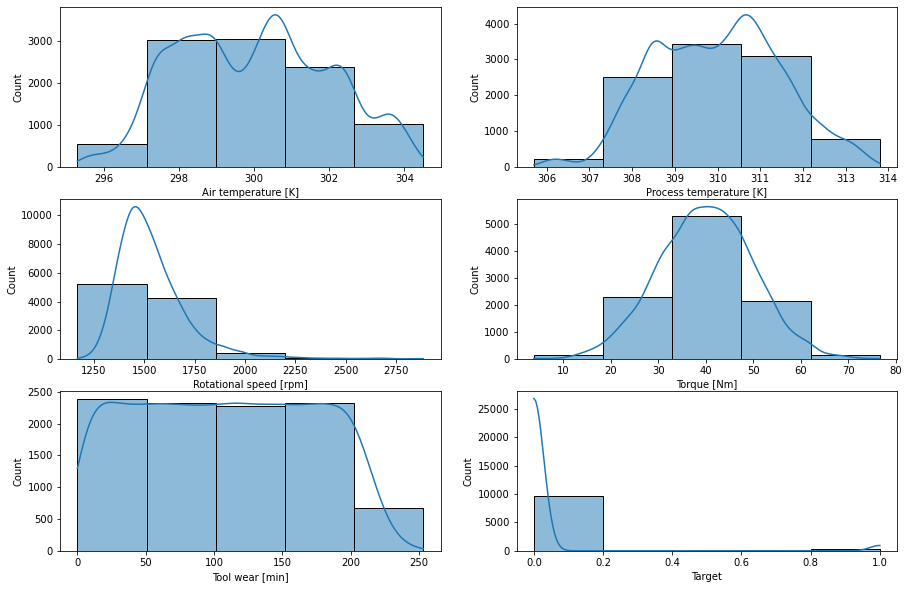

In [13]:
# Histogram plots for continuous features.
plt.figure(figsize=(15,10))
for i,col in enumerate(numerical_ft,1):
    plt.subplot(3,2,i)
    sns.histplot(df[col],kde=True,bins = 5)

- `Air Temperature [k]` looks like a normal distribution , from description mean and median are aligned and 75% of data is close to max value i.e 304.5
- The same is happening with `Process temperature [K]` , seems like they are correlated. lets investigate it further by checking feature importance
- `Rotational speed [rpm]` has mean 1538 , median 1503 -> slightly right skewed probably due to greater max value , the outlier shifted the mean towards right.
- `Torque` in the above figure seems to be normally distributed how ever its description shows that mean and median are aligning together but 75% of data is not close to the max value. This shows that there are potential outliers. let's understands them better moving forward.
- `Tool wear[min]` has mean and median very close but the min and 25% of data is far and from histogram it shows that min value has high count infact of highest of all so it's definitely not a normal distribution.

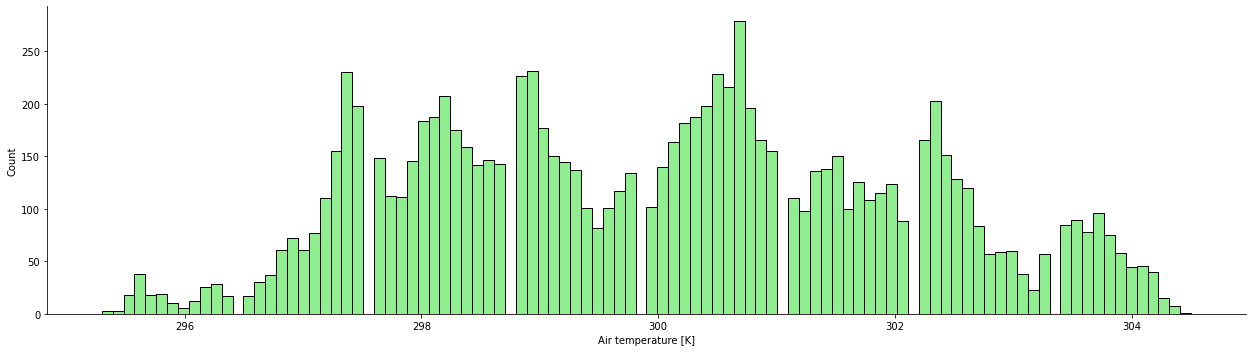

In [14]:
sns.displot(data=df, x="Air temperature [K]", kde=False, bins = 100,color = "blue", facecolor = "lightgreen",height = 5, aspect = 3.5);


From above distribution plot it shows that `Air temperature [k]` doesn't have continuous data. lets check Q-Q plot for more clarification.

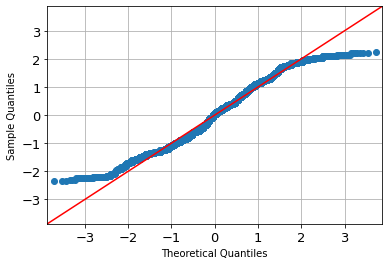

In [15]:
#checking the distribution of independent variables
fig=qqplot(df["Air temperature [K]"],line='45',fit='True')
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.grid(True)
plt.show()


Above Q-Q plot shows that despite not having a continuous distribution `Air temperature [K]` is closely following normal distribution but have outliers.

Now, lets understand how each feature is distributed with respect to target variable.

In [16]:
numerical_ft

['Air temperature [K]',
 'Process temperature [K]',
 'Rotational speed [rpm]',
 'Torque [Nm]',
 'Tool wear [min]',
 'Target']

In [17]:
# A function to get KDE plots for each numerical feature
def univariate_kde(feature , df):
    fig, axs = plt.subplots(1, 1, figsize=(15, 5))
    sns.kdeplot(df.loc[(df['Target']==0),
            feature], color='b', shade=True, label='Not a Failure')  
    sns.kdeplot(df.loc[(df['Target']==1),
            feature], color='r', shade=True, label='Failure')
    plt.title(f'Observation of {feature} with Machine failure')
    plt.legend(title='Machine Failure')
    plt.show()
    


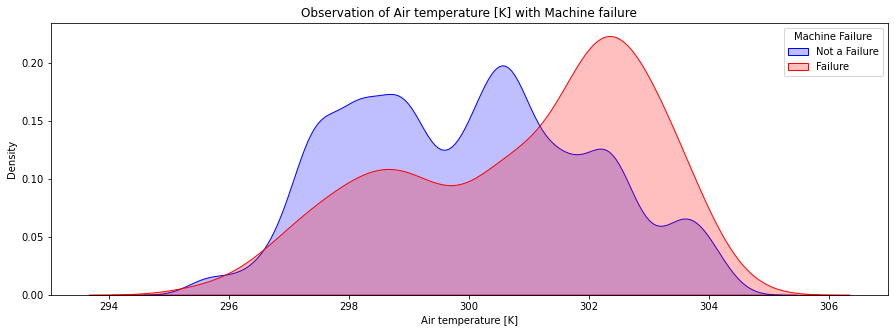

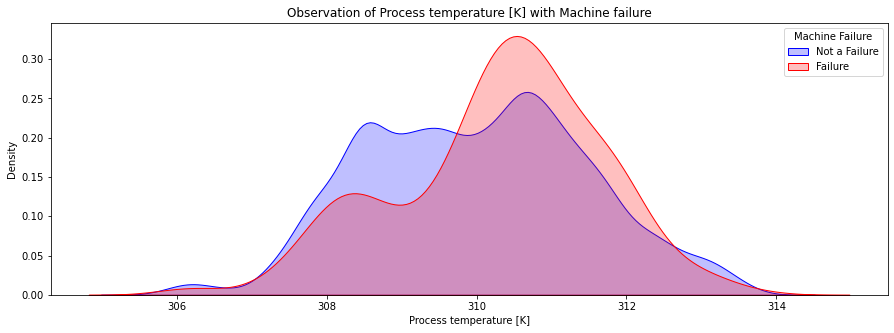

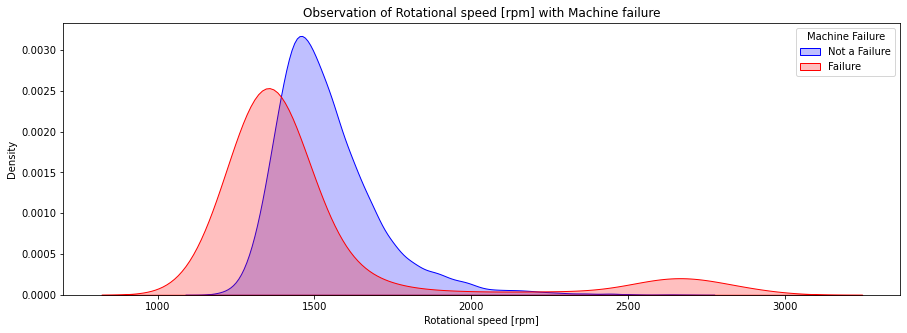

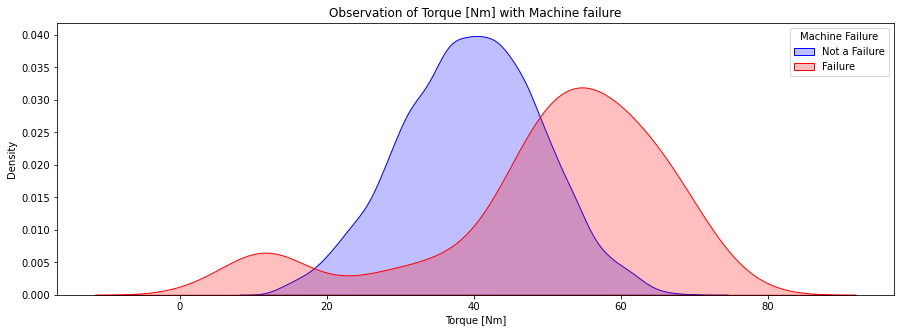

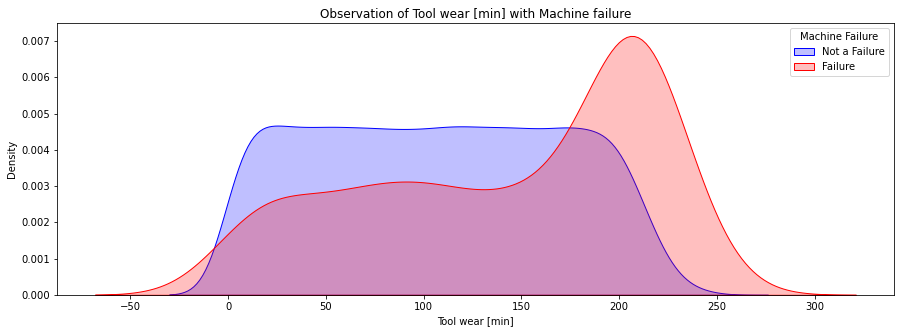

In [18]:
# Iterating over continuous/numerical features to get plots.
for feature in numerical_ft[:-1]:
    univariate_kde(feature,df) #hyperparameters : feature and dataframe with numerical features

### Observations
- `Tool wear` shows high volume of failures down the line and it showed a peak after 150 min
- High `Torque` is a indicator of Machine failure.
- low `Rotational speed [rpm]` is also causing high failures, this can be due to the fact that machines break down or stop working on low speed and the power allocated to feed the loads connected to the system will be lost
- After 309k `Process temperature [K]` the failure rate has suddenly increased




<AxesSubplot:>

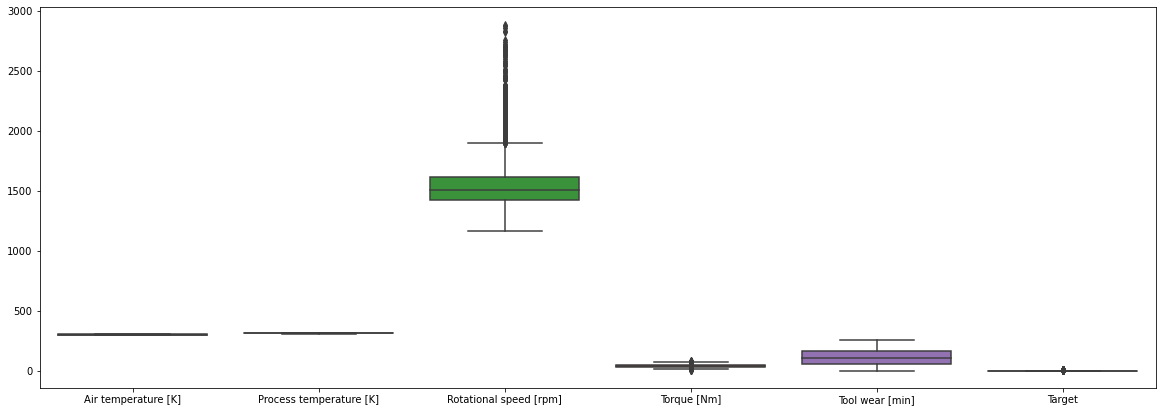

In [19]:
# checking distribution and ranges of predictor variables
plt.figure(figsize=(20,7))
sns.boxplot(data = df)

#### Does the data has Outliers?

Yes, the boxplot shows that there are visible outliers in `Rotational speed [rpm]` and should be imputed moving forward. This should be done before scaling to avoid skewness in data distribution.


<AxesSubplot:>

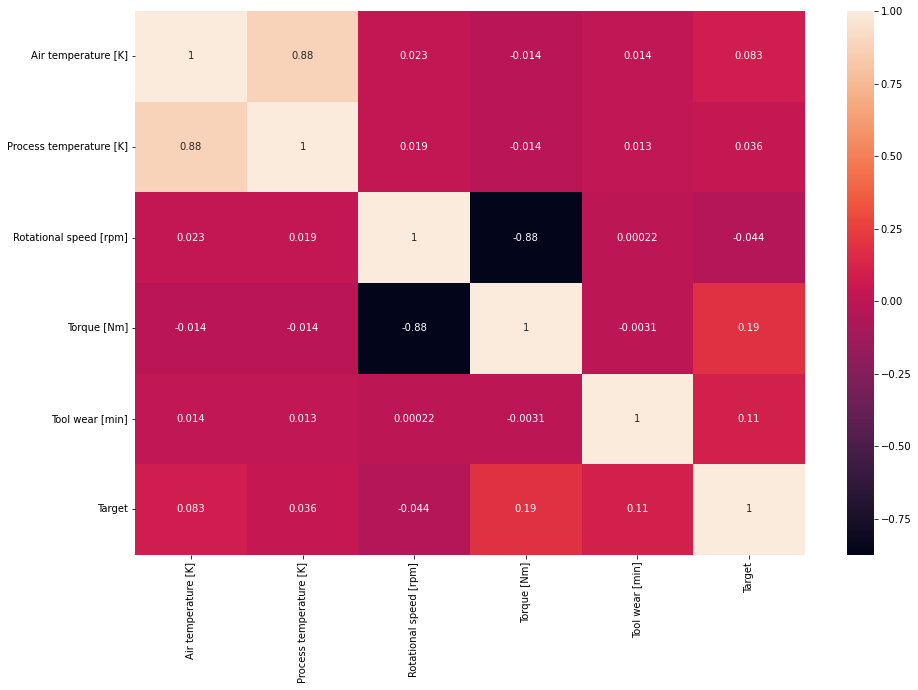

In [20]:
# heatmap

plt.figure(figsize=(15,10))
sns.heatmap(df.corr(),annot = True)

- `Air temperature [K]` and `Process temperature [K]` are positively correlated
- `Torque [Nm]` and `Rotational speed [rpm]` are negatively correlated.
- `Target` shows some correlation with `Torque [Nm]` comparing to other features.

### Pairplot

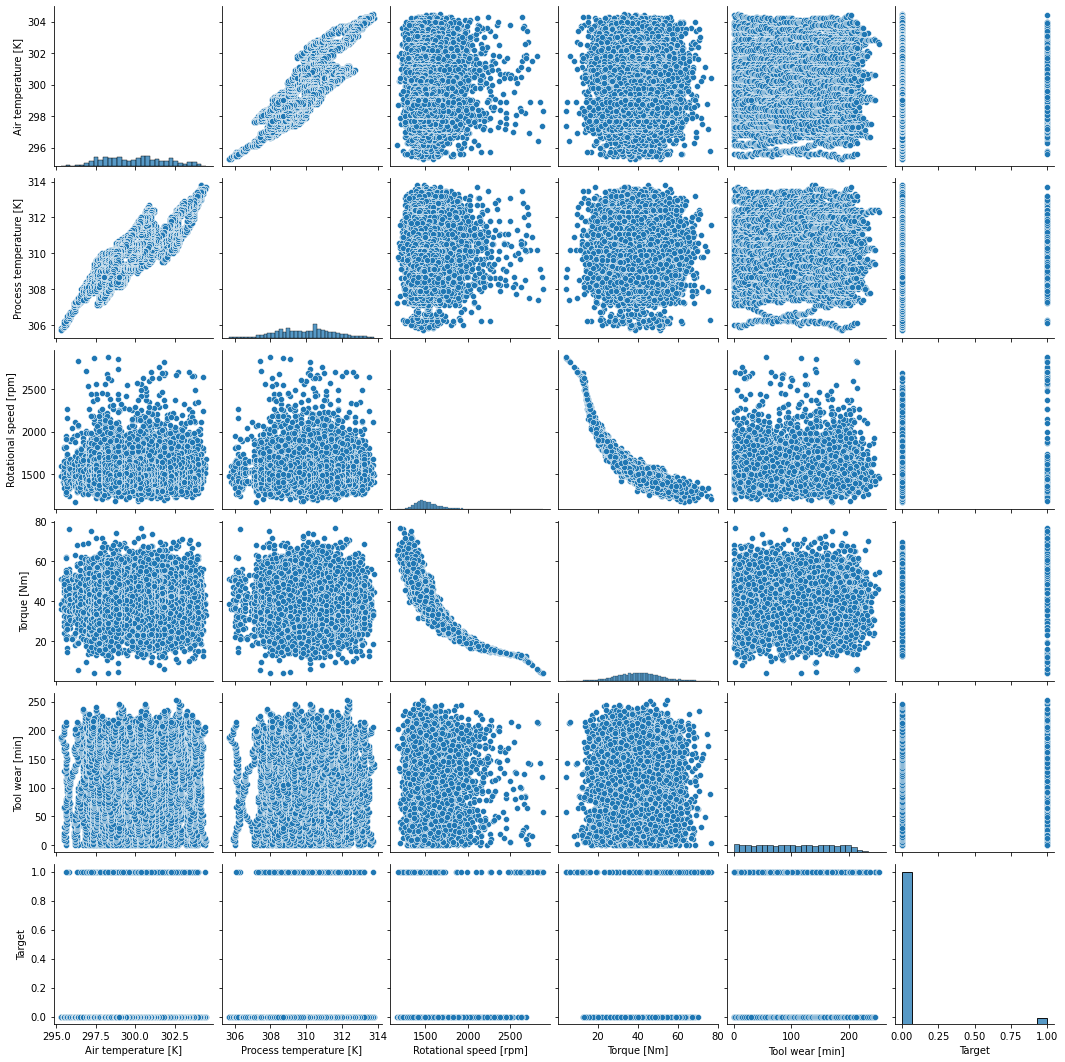

In [21]:
#  To understand relationship between variables
sns.pairplot(df)

From the above plot
- `Process temperature [K]` and `Air temperature [K]` are highly linearly correlated.
-  `Rotational speed [rpm]` and `Torque [Nm]` seems to have a quadratic relationship
- It looks like there is more `Tool wear [min]` in low `Rotational speed [rpm]` thank when it is high i.e they are negatively correlated.

In [22]:
# saving a copy of df to use it for modeling with outliers
df_with_outliers = df.copy()

### Outlier handling


 Inter Quantile Range Method:
- IQR is a concept in statistics that is used to measure the statistical dispersion and data variability by dividing the dataset into quartiles.
- Q1 (1st Quantile) = df.quantile(0.25)
- Q3 (3rd Quantile)= df.quantile(0.75)
- IQR = Q3-Q1
- LowerLimit = Q1-1.5*IQR
- UpperLimit = Q3+1.5*IQR
why we use 1.5 as a factor --> as Standard Devaiation method, 1 IQR from Q1 & Q2 covers approx ~70% of the data and 2 IQR covers approx ~ 97% of the data. so it is aproximated that 1.5 factor will cover approx ~95% of the data.
Anything outside the`LowerLimit` and `UpperLimit` are can be replaced with Median or Mean or Mode.

In [23]:
#  using IQR method to impute outliers
def handle_outliers_iqr(df, feature,fac): # df = dataframe , feature = each feature , fac = 1.5 or 2 based on the use case
    Qan1 = df[f"{feature}"].quantile(0.25)
    Qan3 = df[f"{feature}"].quantile(0.75)
    IQR=Qan3-Qan1
    lower_limit=Qan1-fac*IQR
    upper_limit=Qan3+fac*IQR
    df.loc[(df[feature] < lower_limit) | (df[feature] > upper_limit), feature] = df[feature].mean()
    return df



In [24]:
handle_outliers_iqr(df , "Rotational speed [rpm]" , 1.5)
handle_outliers_iqr(df , "Torque [Nm]" , 1.5)

,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Target
0,M,298.1,308.6,1551.0,42.8,0,0
1,L,298.2,308.7,1408.0,46.3,3,0
2,L,298.1,308.5,1498.0,49.4,5,0
3,L,298.2,308.6,1433.0,39.5,7,0
4,L,298.2,308.7,1408.0,40.0,9,0
...,...,...,...,...,...,...,...
9995,M,298.8,308.4,1604.0,29.5,14,0
9996,H,298.9,308.4,1632.0,31.8,17,0
9997,M,299.0,308.6,1645.0,33.4,22,0
9998,H,299.0,308.7,1408.0,48.5,25,0


In [25]:
df[["Rotational speed [rpm]"]].describe(), df[["Rotational speed [rpm]"]].quantile(0.25), df[["Rotational speed [rpm]"]].quantile(0.75)

(       Rotational speed [rpm]
 count            10000.000000
 mean              1515.231441
 std                127.833761
 min               1168.000000
 25%               1423.000000
 50%               1503.000000
 75%               1589.000000
 max               1895.000000,
 Rotational speed [rpm]    1423.0
 Name: 0.25, dtype: float64,
 Rotational speed [rpm]    1589.0
 Name: 0.75, dtype: float64)

In `Rotational speed [rpm]`

(1589.0-1423.0) = 166(IQR)

1423-249 = 1174 ,

1589(75% value)+249(1.5 times IQR) = 1838
- outliers in the region 1838 and 1895(max value) are handled and replaced by mean 
- outlier between 1589 and 1838 are considered in the distribution and significant

<AxesSubplot:>

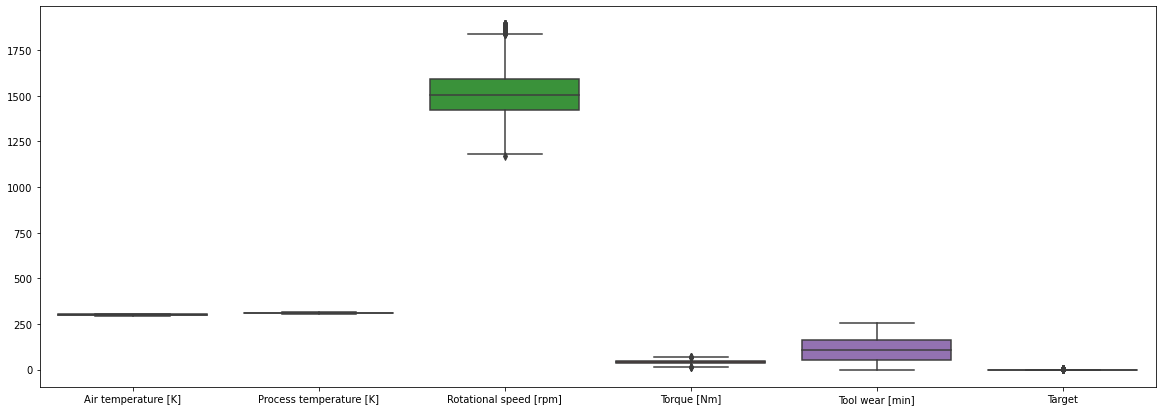

In [26]:
plt.figure(figsize=(20,7))
sns.boxplot(data = df)

#### The above diagram shows that all the predictors are not in the same range. So, it is advisable to scale all the features in same range for better modelling.
#### Scaling can be done in different ways like
1. Normalizing
2. Standardizing

- Normalization is effective when you know that your data is not following a Gaussian distribution(bell curve) and it scales the data in between 0 and 1.
- Standardization can be used when the data follows Gaussian distribution. However it need not necessarily be the exact Gaussian distribution but it is effective on a gaussianlly distributed data.


In [27]:


# Normalizing the data in the rings column beacuse the value is too high when compared to other independent variable

from sklearn import preprocessing

num_feat = ["Air temperature [K]","Process temperature [K]","Rotational speed [rpm]","Torque [Nm]","Tool wear [min]"]
# Create x to store scaled values as floats
x = df[num_feat].values.astype(float)

# Preparing for normalizing
min_max_scaler = preprocessing.MinMaxScaler()

# Transform the data to fit minmax processor
x_scaled = min_max_scaler.fit_transform(x)

# Run the normalizer on the dataframe
df[num_feat] = pd.DataFrame(x_scaled)

<AxesSubplot:>

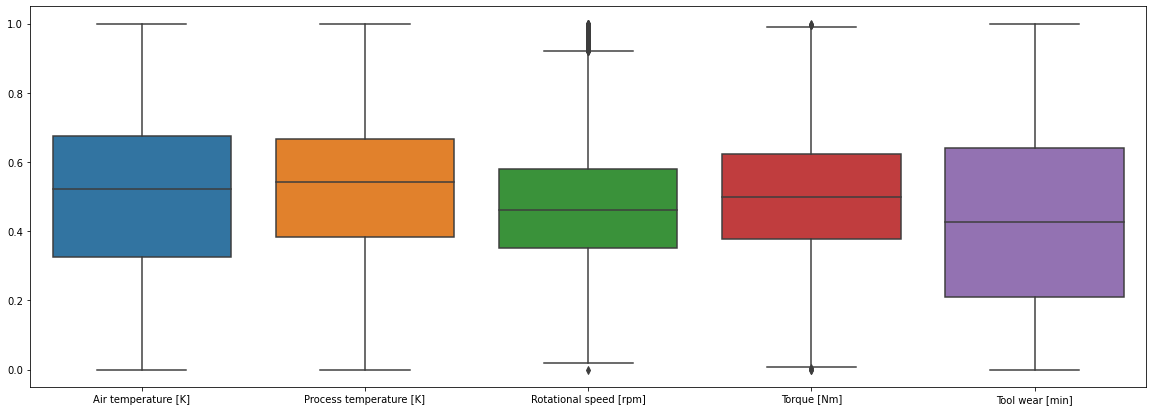

In [29]:
# plotting box plot again to check the distribution after outlier handling
plt.figure(figsize=(20,7))
sns.boxplot(data = df[num_feat])

All features are in same scale and are comparible. Few features still have variance in data 




### Ordinal Encoder

To order the rank of features , in this case L,M,H has ordering like low, medium and high so ordinal encoders are used to preserve the order of the data points

In [30]:
Type_encoder = ce.OrdinalEncoder(cols=['Type'], return_df=True, mapping=[{'col':'Type','mapping':{'L':1,'M':2,'H':3}}])
df['Type'] = Type_encoder.fit_transform(df['Type'])




In [31]:
df

,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Target
0,2,0.304348,0.358025,0.526823,0.551852,0.000000,0
1,1,0.315217,0.370370,0.330124,0.616667,0.011858,0
2,1,0.304348,0.345679,0.453920,0.674074,0.019763,0
3,1,0.315217,0.358025,0.364512,0.490741,0.027668,0
4,1,0.315217,0.370370,0.330124,0.500000,0.035573,0
...,...,...,...,...,...,...,...
9995,2,0.380435,0.333333,0.599725,0.305556,0.055336,0
9996,3,0.391304,0.333333,0.638239,0.348148,0.067194,0
9997,2,0.402174,0.358025,0.656121,0.377778,0.086957,0
9998,3,0.402174,0.370370,0.330124,0.657407,0.098814,0


## Feature Importance
Few independent variables contribute a lot in predicting target variable and few don't. This can be understood through various methods and helps in eliminating variables that contribute's less in the analysis

### Heat Map

Heatmap shows the magnitude of a feature by visualizing the intensity through colours and helps in understanding features that matters the most

<AxesSubplot:>

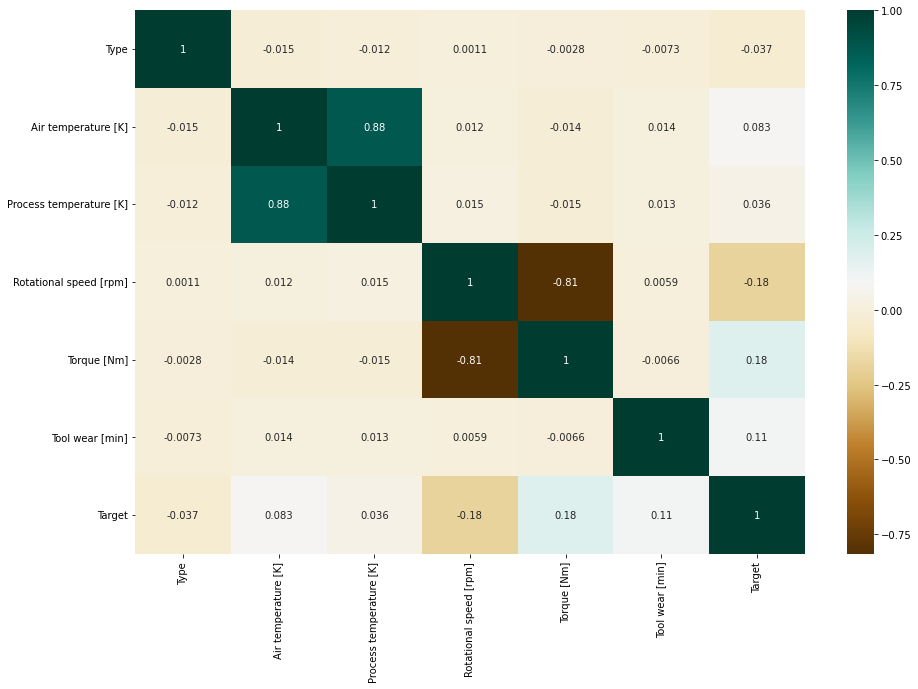

In [32]:
plt.figure(figsize=(15,10))
sns.heatmap(df.corr(),annot = True,cmap="BrBG")

### Observations
- Above heapmap shows that `Air teamperature [k]` and `Process temperature [k]` are highly correlated.
- `Torque` has high correlation comparing to other feature with Target
- `Torque` and `Rotational speed [Nm]` are negatively correlated i.e if Rotational speed increases then Torque decreases and vice versa.
- `Type` has slight correlation with `Rotational speed [Nm]` comparing to other features but it doesn't seem like multi colinearity as the value is very low.


As its important to check whether the both the correlated features are necessary for prediction or should one of them be removed.

`Air teamperature [k]` and  `Process temperature [k]` are gaving 0.88 correlated to each other and `Air teamperature [k]` w.r.t `Target` has 0.083 while `Process temperature [k]` w.r.t `Target` has 0.036 which shows that one can be removed and it is `Process temperature [k]`  let's strongly confirm with permutation importance menthod later.

To see interaction between independent features let's check correlation through pariplot

### OLS regression

Ordinary Lease Square Regressions tell us relationship between one or more independent variables with a dependent variable

In [33]:
cols = df.columns.tolist()
cols.remove("Target")
model = sm.OLS(df['Target'], df[cols]).fit()
model.summary() #sumarizes the stats

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                 Target   R-squared (uncentered):                   0.093
Model:                            OLS   Adj. R-squared (uncentered):              0.092
Method:                 Least Squares   F-statistic:                              170.7
Date:                Sun, 09 Oct 2022   Prob (F-statistic):                   1.80e-207
Time:                        23:40:37   Log-Likelihood:                          3220.3
No. Observations:               10000   AIC:                                     -6429.
Df Residuals:                    9994   BIC:                                     -6385.
Df Model:                           6                                                  
Covariance Type:            nonrobust                                                  
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Type                       -0.0086      0.003     -3.391      0.001      -0.014      -0.004
Air temperature [K]         0.1808      0.017     10.810      0.000       0.148       0.214
Process temperature [K]    -0.1486      0.020     -7.591      0.000      -0.187      -0.110
Rotational speed [rpm]     -0.1044      0.009    -11.947      0.000      -0.121      -0.087
Torque [Nm]                 0.1006      0.008     11.956      0.000       0.084       0.117
Tool wear [min]             0.0770      0.007     11.207      0.000       0.064       0.090
==============================================================================
Omnibus:                     9198.513   Durbin-Watson:                   1.914
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           231291.380
Skew:                           4.686   Prob(JB):                         0.00
Kurtosis:                      24.617   Cond. No.                         27.9
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

The above stats show that all the features have p value < 0.05 so they are significant

### Permutation Importance

In [34]:
def get_permutation_importance(df):
    X = df[["Type","Air temperature [K]","Process temperature [K]","Rotational speed [rpm]","Torque [Nm]","Tool wear [min]"]]
    y = df[["Target"]]
    X_t, X_test, y_t, y_test = train_test_split(X, y, test_size=0.20, random_state=1)
    X_train, X_val, y_train, y_val = train_test_split(X_t, y_t, test_size=0.10, random_state=1)
    # Create linear regression object
    model = linear_model.LinearRegression()
    model.fit(X_train,y_train)
    pi = PermutationImportance(model, random_state=1).fit(X_test, y_test)
    return eli5.show_weights(pi, feature_names = X_test.columns.tolist())



#  https://scikit-learn.org/stable/modules/permutation_importance.html

In [35]:
get_permutation_importance(df)

Weight,Feature
0.1266 ± 0.0227,Air temperature [K]
0.0532 ± 0.0178,Process temperature [K]
0.0235 ± 0.0136,Rotational speed [rpm]
0.0193 ± 0.0074,Tool wear [min]
0.0137 ± 0.0070,Torque [Nm]
0.0017 ± 0.0052,Type


From above scores it is evident that `Process temperature [K]` has low importance than `Air temperature [K]` in model prediction , let's go ahead and remove `Process temperature [K]`


In [36]:
df = df.drop("Process temperature [K]",axis = 1)

In [37]:
df

,Type,Air temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Target
0,2,0.304348,0.526823,0.551852,0.000000,0
1,1,0.315217,0.330124,0.616667,0.011858,0
2,1,0.304348,0.453920,0.674074,0.019763,0
3,1,0.315217,0.364512,0.490741,0.027668,0
4,1,0.315217,0.330124,0.500000,0.035573,0
...,...,...,...,...,...,...
9995,2,0.380435,0.599725,0.305556,0.055336,0
9996,3,0.391304,0.638239,0.348148,0.067194,0
9997,2,0.402174,0.656121,0.377778,0.086957,0
9998,3,0.402174,0.330124,0.657407,0.098814,0



### Oversampling


Data in target variable is not balanced so over sampling is required and it helps in building a model with decent scores

In [38]:
class_Fail = df[df['Target'] == 0]
class_No_Fail = df[df['Target'] == 1]
class_No_Fail = class_No_Fail.sample(len(class_Fail),replace=True)
over_sampled_df = pd.concat([class_Fail, class_No_Fail], axis=0)


print('OverSampled Data Distribution:\n',over_sampled_df['Target'].value_counts())



OverSampled Data Distribution:
 0    9661
1    9661
Name: Target, dtype: int64


In [39]:
over_sampled_df

,Type,Air temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Target
0,2,0.304348,0.526823,0.551852,0.000000,0
1,1,0.315217,0.330124,0.616667,0.011858,0
2,1,0.304348,0.453920,0.674074,0.019763,0
3,1,0.315217,0.364512,0.490741,0.027668,0
4,1,0.315217,0.330124,0.500000,0.035573,0
...,...,...,...,...,...,...
9174,1,0.271739,0.966988,0.233333,0.790514,1
9830,1,0.326087,0.232462,0.798148,0.814229,1
4844,2,0.880435,0.203576,0.701852,0.272727,1
4207,2,0.760870,0.745530,0.322222,0.861660,1


### Train , Test and validation split

In [40]:
independent_cols = ["Type","Air temperature [K]","Rotational speed [rpm]","Torque [Nm]","Tool wear [min]"]

X = over_sampled_df[independent_cols]
y = over_sampled_df["Target"]

In [41]:
X_t, X_test, y_t, y_test = train_test_split(X, y, test_size=0.1, random_state=1)

X_train, X_val, y_train, y_val = train_test_split(X_t, y_t, test_size=0.15, random_state=1)



# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html

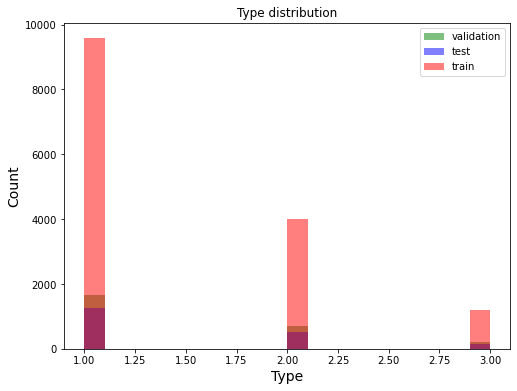

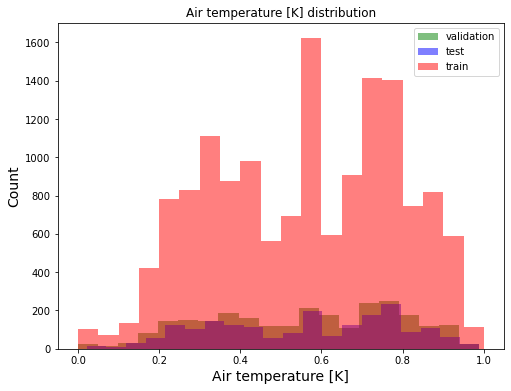

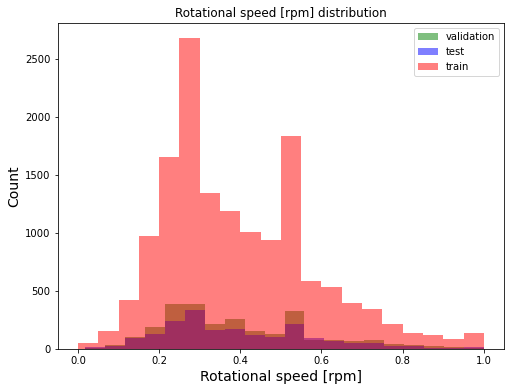

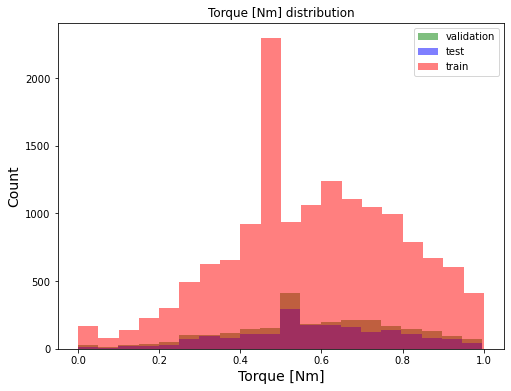

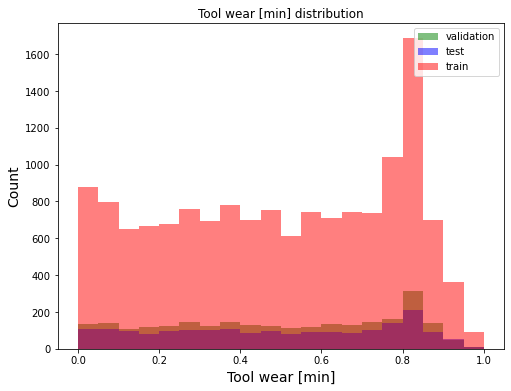

In [42]:
# Looking the data for test, training and validation set
X_test_plot = X_test[independent_cols]

X_val_plot = X_val[independent_cols]

X_train_plot = X_train[independent_cols]

# Plotting the data to see the histogram
for col in X_test_plot.columns[:]:
    plt.figure(figsize=(8,6))
    plt.hist(X_val_plot[col], bins=20, alpha=0.5, label="validation",color = 'g')
    plt.hist(X_test_plot[col], bins=20, alpha=0.5, label="test",color = 'b')
    plt.hist(X_train_plot[col], bins=20, alpha=0.5, label="train",color = 'r')
    plt.xlabel(col, size=14)
    plt.ylabel("Count", size=14)
    
    plt.legend(loc='upper right')
    plt.title("{} distribution".format(col))
    plt.show()
 

#### Do the training and test sets have the same data?

Yes, from above graphs its evident that the distributions are almost same for all train , test and validation sets except few mid values in `Tool wear [min]` .

## Modeling

In [43]:
# def log_regression(df):
# #     

#### With imputed Outliers

In [44]:
#Implementing Logistic Regression using sklearn
modelLogistic = LogisticRegression()
modelLogistic.fit(X_train,y_train)

#printing the regression coefficients

print("The intercept b0= ", modelLogistic.intercept_)

print("The coefficient b1= ", modelLogistic.coef_)




The intercept b0=  [-0.01324617]
The coefficient b1=  [[-0.26913297  1.92412831 -6.28943222  0.99656894  2.35625898]]


In [45]:
lr_y_predict = modelLogistic.predict(X_test)

print("Model Performance with Test set")

d = [ ["Accuracy_score", f'{round(accuracy_score(y_test,lr_y_predict),2)}'],
     ["Precission_score", f'{round(precision_score(y_test,lr_y_predict),2)}'],
     ["Recall_score", f'{round(recall_score(y_test,lr_y_predict),2)}'],
     ["F1-score",f'{round(f1_score(y_test,lr_y_predict),2)}']]

print(tabulate(d, headers=["Metrics", "Score"]))
# Make predictions using the validation set
y_val_pred = modelLogistic.predict(X_val)
print("-----------------------------------------------")
print("Model Performance with validation set")

d = [ ["Accuracy_score", f'{round(accuracy_score(y_val,y_val_pred),2)}'],
     ["Precission_score", f'{round(precision_score(y_val,y_val_pred),2)}'],
     ["Recall_score", f'{round(recall_score(y_val,y_val_pred),2)}'],
     ["F1-score",f'{round(f1_score(y_val,y_val_pred),2)}']]

print(tabulate(d, headers=["Metrics", "Score"]))

Model Performance with Test set
Metrics             Score
----------------  -------
Accuracy_score       0.79
Precission_score     0.76
Recall_score         0.82
F1-score             0.78
-----------------------------------------------
Model Performance with validation set
Metrics             Score
----------------  -------
Accuracy_score       0.76
Precission_score     0.75
Recall_score         0.78
F1-score             0.77


# final
EDA - check data distribution , box plots, heat maps(only numerical) , so far no encoding , will know missing and outliers
- missing values impute for both categorical and numerical , outlier handling and then scaling (needs outlier handling to avoid skewness)
- encoding for categorical 

now we have all numerical data eda and preprocessing done

- now check heatmap with all numerical data , and ols regression , VIF for knowing more dependent feature.
so far features selected 

train test split
permutation 
remove feature from train and test for modeling

make sure that we have same distritbutio in train and test

- check if train test val have same distribution before final modeling



#### With Outliers

#### Ordinal Encoding with outliers

In [46]:
Type_encoder = ce.OrdinalEncoder(cols=['Type'], return_df=True, mapping=[{'col':'Type','mapping':{'L':1,'M':2,'H':3}}])
df_with_outliers['Type'] = Type_encoder.fit_transform(df_with_outliers['Type'])


#### Oversampling with outliers

In [47]:
class_Fail_out = df_with_outliers[df_with_outliers['Target'] == 0]
class_No_Fail_out = df_with_outliers[df_with_outliers['Target'] == 1]
class_No_Fail_out = class_No_Fail_out.sample(len(class_Fail_out),replace=True)
over_sampled_df_out = pd.concat([class_Fail_out, class_No_Fail_out], axis=0)

#### Train , Test and Validation split with outliers

In [48]:
independent_cols = ["Type","Air temperature [K]","Rotational speed [rpm]","Torque [Nm]","Tool wear [min]"]

X_out = over_sampled_df_out[independent_cols]
y_out = over_sampled_df_out["Target"]

In [49]:
# splitting train and test data
X_t_out, X_test_out, y_t_out, y_test_out = train_test_split(X_out, y_out, test_size=0.1, random_state=1)

X_train_out, X_val_out, y_train_out, y_val_out = train_test_split(X_t_out, y_t_out, test_size=0.15, random_state=1)



In [50]:
modelLogistic_out = LogisticRegression()
modelLogistic_out.fit(X_train_out,y_train_out)


LogisticRegression()

In [51]:
lr_y_predict_out = modelLogistic_out.predict(X_test_out)

print("Model Performance with Test set")

d = [ ["Accuracy_score", f'{round(accuracy_score(y_test_out,lr_y_predict_out),2)}'],
     ["Precission_score", f'{round(precision_score(y_test_out,lr_y_predict_out),2)}'],
     ["Recall_score", f'{round(recall_score(y_test_out,lr_y_predict_out),2)}'],
     ["F1-score",f'{round(f1_score(y_test_out,lr_y_predict_out),2)}']]

print(tabulate(d, headers=["Metrics", "Score"]))
# Make predictions using the validation set
y_val_pred_out = modelLogistic_out.predict(X_val_out)
print("-----------------------------------------------")
print("Model Performance with validation set")

d = [ ["Accuracy_score", f'{round(accuracy_score(y_val_out,y_val_pred_out),2)}'],
     ["Precission_score", f'{round(precision_score(y_val_out,y_val_pred_out),2)}'],
     ["Recall_score", f'{round(recall_score(y_val_out,y_val_pred_out),2)}'],
     ["F1-score",f'{round(f1_score(y_val_out,y_val_pred_out),2)}']]

print(tabulate(d, headers=["Metrics", "Score"]))

Model Performance with Test set
Metrics             Score
----------------  -------
Accuracy_score       0.77
Precission_score     0.78
Recall_score         0.73
F1-score             0.75
-----------------------------------------------
Model Performance with validation set
Metrics             Score
----------------  -------
Accuracy_score       0.75
Precission_score     0.78
Recall_score         0.7
F1-score             0.74


####  Remove outliers and keep outliers (does if have an effect of the final predictive model)?

Yes, it does have a small difference in scores with and with out outliers.

with outliers :

- Accuracy , recall and F1-scores are lower than model with imputed outlier data
- In test set there is a slight increase in precision with outliers
- With validation data all scores are less than imputed outlier data model


with outlier Imputation:

- Scores in Test set have increased when outliers are imputed comparing to the one with outliers

To conclude, there is an improvement in scores with imputed outliers. This can possibly be due to better distribution after outlier imputation.

### Imputing Null values

In [52]:
def null_impute_with_mean(percent , feature , impute_feature):
    df_null = df_copy.copy()
    df_null[f"{impute_feature}"] = df_null[f"{feature}"]

    df_null.loc[df_null.sample(frac=percent).index,f'{impute_feature}'] = np.NaN



    # Imputing Null values with mean

    df_null[f"{impute_feature}"] = df_null[f"{impute_feature}"].fillna(df_null[f"{impute_feature}"].mean()) 
    mse = mean_squared_error(df_null[f"{feature}"], df_null[f"{impute_feature}"])

    print(f"Error after imputing {percent*100} values is {round(mse,2)*100}%")

In [53]:
#  Removing 1% data and imputing
null_impute_with_mean(0.01 ,"Air temperature [K]" ,"Air temperature [K]_imputed")

Error after imputing 1.0 values is 4.0%


In [54]:
#  Removing 5% data and imputing with mean

null_impute_with_mean(0.05 ,"Air temperature [K]" ,"Air temperature [K]_imputed")

Error after imputing 5.0 values is 20.0%


In [55]:
#  Removing 10% data and imputing

null_impute_with_mean(0.10 ,"Air temperature [K]" ,"Air temperature [K]_imputed")

Error after imputing 10.0 values is 39.0%


In [56]:
# Imputing Null values with Mode

def null_impute_with_median(percent , feature , impute_feature):
    df_null = df_copy.copy()
    df_null[f"{impute_feature}"] = df_null[f"{feature}"]

    
    df_null.loc[df_null.sample(frac=percent).index,f'{impute_feature}'] = np.NaN



    # Imputing Null values with mean

    df_null[f"{impute_feature}"] = df_null[f"{impute_feature}"].fillna(df_null[f"{impute_feature}"].median()) 
    mse = mean_squared_error(df_null[f"{feature}"], df_null[f"{impute_feature}"])

    print(f"Error after imputing {percent*100} values is {round(mse,2)*100}%")

In [57]:
#  Removing 1% data and imputing
null_impute_with_median(0.01 ,"Air temperature [K]" ,"Air temperature [K]_imputed")

Error after imputing 1.0 values is 3.0%


In [58]:
#  Removing 5% data and imputing
null_impute_with_median(0.05 ,"Air temperature [K]" ,"Air temperature [K]_imputed")

Error after imputing 5.0 values is 19.0%


In [59]:
#  Removing 10% data and imputing
null_impute_with_median(0.10 ,"Air temperature [K]" ,"Air temperature [K]_imputed")

Error after imputing 10.0 values is 39.0%


There are no high significant difference in error other than 2-3% by imputing mean and median respectively

### Confusion Matrix

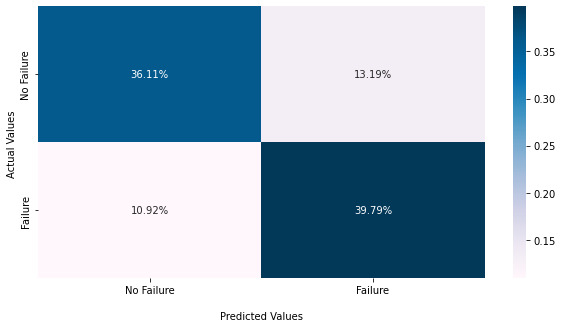

In [60]:
con_matrix = confusion_matrix(y_val,y_val_pred)
plt.figure(figsize=(10,5))
ax = sns.heatmap(con_matrix/np.sum(con_matrix),fmt='.2%', annot=True, cmap='PuBu')
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');
ax.xaxis.set_ticklabels(['No Failure','Failure'])
ax.yaxis.set_ticklabels(['No Failure','Failure'])
plt.show()

### Conclusion

From above analysis

* The data has both numerical and categorical
* `Rotational speed [rpm]` has extreme outliers and handled later for improved results
* over sampling helped in getting more data as the target distribution is unbalanced
* The data has no null values 
* Feature scaling is done using min max scaler to get all the feature range between 0 and 1 
* Multi colinearity is observed in some features and removed it after checking permutation importance
* Important features are selected and considered for modeling
* Slight difference in model performance is observed with outlier unhandled vs outliers handled


### Refrences:

1. GeeksForGeeks Quantile-Quantile plot documentation https://www.geeksforgeeks.org/qqplot-quantile-quantile-plot-in-python/
2. Matplotlib documentation
3. Outlier handling is referec from analytics vidhya outlier handling theoritical explanation https://www.analyticsvidhya.com/blog/2021/05/detecting-and-treating-outliers-treating-the-odd-one-out/
4. permutation importance is refered from scikit-learn permutation handling concept document https://scikit-learn.org/stable/modules/permutation_importance.html
5. modeling is refered from scikit-learn logistic regression officiakl documentatio
6. Outlier Imputation is refered from sklearn "logistic-regression-using-python-and-excel" explanation
7. Refered Kaggle contributions for oversampling 
8. https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html

All other code and function implementation are independently written.


Copyright 

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.